In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
import os
import torch
import torch.optim as optim

from networks import *
from helper_fn import *

%load_ext autoreload
%autoreload 2

In [2]:
train_data = torch.tensor(np.load("data/fluid_train.npy")).float()
val_data = torch.tensor(np.load("data/fluid_val.npy")).float()

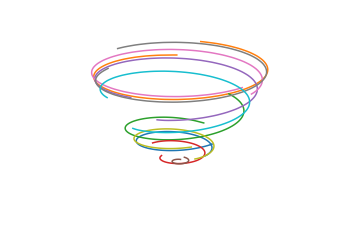

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in np.random.randint(0, len(train_data)-1, 10):
    ax.plot(train_data[i, :, 0].numpy(), train_data[i, :, 1].numpy(), train_data[i, :, 2].numpy())
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 1])
ax.set_axis_off()
plt.show()

In [4]:
from helper_fn import *
from networks import *

RESET_LOGS = False

CPT = "model-denis-50-1579778231"

if len(CPT)!=0:
    MODEL_NAME = "{}".format(CPT)
else:
    MODEL_NAME = "model-denis-50-{}".format(int(time.time()))
    
BATCH_SIZE = 100
EPOCHS = 500

SAVE_METHOD = 'Best'
ROOT_DIR = "logs/denis_fluid"
CPT_DIR = "models/{}.pt".format(CPT)
FIG_DIR = os.path.join(ROOT_DIR, "figures/{}".format(MODEL_NAME))
DIST_DIR = os.path.join(ROOT_DIR, "dists/{}".format(MODEL_NAME))
EIG_DIR = os.path.join(ROOT_DIR, "eigens/{}".format(MODEL_NAME))

CONFIG_DIR = os.path.join(ROOT_DIR, 'model_configs.csv')
SAVE_FIG = True
SAVE_DIST = False
SAVE_EIG = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on {}".format(device))

if not os.path.isdir(FIG_DIR) and SAVE_FIG:
    os.mkdir(FIG_DIR)
    
if not os.path.isdir(DIST_DIR) and SAVE_DIST:
    os.mkdir(DIST_DIR)
    
if not os.path.isdir(EIG_DIR) and SAVE_EIG:
    os.mkdir(EIG_DIR)

log_dir = os.path.join(ROOT_DIR, 'logs.csv')
model_dir = os.path.join(ROOT_DIR, 'models/{}.pt'.format(MODEL_NAME))

encoder_shape = [3, 4, 8, 16, 32, 64, 64, 38]
aux_shape =     [3, 4, 8, 16, 32, 64, 64, 38, encoder_shape[0]+encoder_shape[-1]]

params = {'encoder_shape': encoder_shape, 'aux_shape': aux_shape,'n_shifts': 50,
          'state_loss': 1, 'latent_loss': 10, 'reg_loss': 1e-6, 'inf_loss': 1e-4}

meta_df = save_configs2(MODEL_NAME, params, CONFIG_DIR)

if len(CPT)!=0:
    print("Load from checkpoint: {}".format(CPT_DIR))
    model = torch.load(os.path.join(ROOT_DIR, CPT_DIR)).to(device)
    model.params = params
else:
    print("Initializing new model {}".format(MODEL_NAME))
    model = DENIS(params).to(device)
# load data frame
df = load_df(log_dir, RESET_LOGS)

# initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

Training on cpu
Load from checkpoint: models/model-denis-50-1579778231.pt
Loading logs from logs/denis_fluid/logs.csv


In [5]:
train_data = train_data.to(device)
val_data = val_data.to(device)

In [ ]:
for epoch in range(EPOCHS):
    pbar = tqdm(range(0, len(train_data), BATCH_SIZE))
    for i in pbar:
        model.train()
        batch_X = train_data[i:i+BATCH_SIZE].to(device)
        model.zero_grad()
        
        enc_gt, enc_traj, ko = model(batch_X)

        loss, state_mse, latent_mse, inf_mse = koopman_loss(enc_gt, enc_traj, params)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            model.eval()
            val_enc_gt, val_enc_traj, ko = model(val_data)
            val_loss, val_state_mse, val_latent_mse, val_inf_mse = koopman_loss(val_enc_gt, val_enc_traj, params)

            # save to dataframe
            df.loc[len(df)+1] = [MODEL_NAME, epoch, float(loss), float(val_loss), 
                                 float(state_mse), float(val_state_mse), float(latent_mse), float(val_latent_mse),
                                 float(inf_mse), float(val_inf_mse)]

            # update progress bar
            pbar.set_description("loss: {:.4f}, val_loss: {:.4f}, state_mse: {:.4f}".format(loss, 
                                                                                            val_loss, 
                                                                                            state_mse))
            pbar.refresh()
            
        if i % 1000 == 0:
            if SAVE_FIG:
                fig_dir = os.path.join(FIG_DIR, "{}.png".format(int(time.time())))
                plot_val3D(val_data, model, val_state_mse, fig_dir)
            
        if i % 10000 ==0:
            
            if SAVE_EIG:
                enc_gt, enc_traj, ko = model(train_data[:10000])
                ko = ko.cpu().detach().numpy()
                enc_traj = enc_traj[:, 0, :].cpu().detach().numpy()

                fig_dir = os.path.join(EIG_DIR, "{}.png".format(int(time.time())))
                plot_eigen_func(ko, enc_traj, train_data.cpu()[:10000], fig_dir=fig_dir)
                
            if SAVE_DIST:
                dist_dir = os.path.join(DIST_DIR, "{}.png".format(int(time.time())))
                plot_layers(model.named_parameters(), val_state_mse, dist_dir, n_rows=2)
            
        saver(model, model_dir, df, MODEL_NAME, float(val_loss), SAVE_METHOD)
            
    df.to_csv(log_dir, index=False)               

loss: 0.0002, val_loss: 0.0002, state_mse: 0.0001:   0%|          | 1/200 [00:17<49:19, 14.87s/it]/anaconda3/envs/DKoopman/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DENIS. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/DKoopman/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
loss: 0.0001, val_loss: 0.0002, state_mse: 0.0001: 100%|██████████| 200/200 [10:25<00:00,  3.13s/it]
loss: 0.0001, val_loss: 0.0002, state_mse: 0.0001: 100%|██████████| 200/200 [10:17<00:00,  3.09s/it]
loss: 0.0001, val_loss: 0.0002, state_mse: 0.0001: 100%|██████████| 200/200 [10:25<00:00,  3.13s/it]
loss: 0.0001, val_loss: 0.0001, state_mse: 0.0001: 100%|██████████| 200/200 [11:11<00:00